# Assignment 2
## Steve Cheney
### RBIF110



## Problem 1

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer

from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, AllChem, Descriptors, rdMolDescriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import SaltRemover, PandasTools
from rdkit.DataStructs import FingerprintSimilarity
from rdkit import RDLogger

In [54]:
# Read in the data files

# Assuming you conver the xls to a csv

lc50_data = "FishLC50.csv"
try:
    lc50_df = pd.read_csv(lc50_data, sep=",", encoding="utf-8")
except UnicodeDecodeError:
    lc50_df = pd.read_csv(lc50_data, sep=",", encoding="latin-1")



bbb_data = "BBB_Data.txt"
try:
    bbb_df = pd.read_csv(bbb_data, sep="\t", encoding="utf-8")
except UnicodeDecodeError:
    bbb_df = pd.read_csv(bbb_data, sep="\t", encoding="latin-1")

#lc50_df.head()
#bbb_df.head()


In [55]:
print(lc50_df.columns)

Index(['STRUCTURE_SMILES', 'LC50_mmol'], dtype='object')


In [56]:
def standardize_smiles(smiles):
    '''This function takes a non-canonical SMILES and
    returns the canonical version

    Args:
        -smiles: str, non-canonical SMILES of a molecule

    Out:
        - canonical_smiles: str, canonical SMILES of the molecule
    '''

    # Handle any issues with missing values
    if not isinstance(smiles, str) or smiles.strip() == "" or pd.isna(smiles):
        return None
    
    mol = Chem.MolFromSmiles(smiles) #create a mol object from input smiles


    largest_Fragment = rdMolStandardize.LargestFragmentChooser()    
    standardized_smiles = largest_Fragment.choose(mol) #standardize the input string by taking the largest fragment

    canonical_smiles = Chem.MolToSmiles(standardized_smiles) #convert the previous mol object to SMILES using Chem.MolToSmiles()

    ####END
    return canonical_smiles

def get_standard_mol(smiles):
    '''This function takes a non-canonical SMILES converts to the canonical version, then returns the mol object

    Args:
        -smiles: str, non-canonical SMILES of a molecule

    Out:
        - obj: mol object of the converted canonical molecule
    '''
    
    if smiles is None:
        return None

    try:
        mol_obj = Chem.MolFromSmiles(standardize_smiles(smiles))
        return mol_obj if mol_obj else None
    except:
        return None

def get_fingerprint(mol, radius=2, bits=1024):
    if mol is None:
        return None  # Prevents passing None to the RDKit function
    
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=bits)

# Suppress RDKit warnings and informational messages
RDLogger.DisableLog('rdApp.*')  # Disables all RDKit logging messages

def clean_df_and_create_mol_col(df, smilesCol, molCol, subset_len=-1, remove_na=True):

    if subset_len == -1:
        data_subset = df.copy()
    else:
        data_subset = df.iloc[:subset_len].copy()

    # Clean data
    data_subset = data_subset[data_subset[smilesCol].notna()]  # Remove NaN values
    data_subset[smilesCol] = data_subset[smilesCol].astype(str)  # Ensure all values are strings

    PandasTools.AddMoleculeColumnToFrame(data_subset, smilesCol=smilesCol, molCol=molCol)

    return data_subset

def calculate_descriptors(mol):
    if mol:
        return {
            "Molecular_Weight": Descriptors.MolWt(mol),
            "Rotatable_Bonds": Descriptors.NumRotatableBonds(mol),
            "Aromatic_Bonds": rdMolDescriptors.CalcNumAromaticRings(mol),
            "ClogP": Descriptors.MolLogP(mol),
            "TPSA": Descriptors.TPSA(mol),
        }
    else:
        return None

In [57]:
# Clean the data to ignore any NaN smiles values and subset data if needed
lc50_df = clean_df_and_create_mol_col(lc50_df, 'STRUCTURE_SMILES', 'rdkit_mol')
# Get the standardized mol object from the standard SMILES
lc50_df['standardized_mol'] = lc50_df['STRUCTURE_SMILES'].apply(get_standard_mol)
# Get the fingerprint
lc50_df['fingerprint'] = lc50_df['standardized_mol'].apply(get_fingerprint)
lc50_df.head()

,STRUCTURE_SMILES,LC50_mmol,rdkit_mol,standardized_mol,fingerprint
0,OCCN(CCO)CCO,79.100,<rdkit.Chem.rdchem.Mol object at 0x0000024748F...,<rdkit.Chem.rdchem.Mol object at 0x00000247489...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CN(C)N,0.131,<rdkit.Chem.rdchem.Mol object at 0x000002474C4...,<rdkit.Chem.rdchem.Mol object at 0x000002474FC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,NCCCN,16.100,<rdkit.Chem.rdchem.Mol object at 0x000002474C4...,<rdkit.Chem.rdchem.Mol object at 0x000002474FC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,OCCNCCO,44.800,<rdkit.Chem.rdchem.Mol object at 0x000002474C4...,<rdkit.Chem.rdchem.Mol object at 0x000002474FC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CS(=O)C,435.000,<rdkit.Chem.rdchem.Mol object at 0x000002474C4...,<rdkit.Chem.rdchem.Mol object at 0x000002474FC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


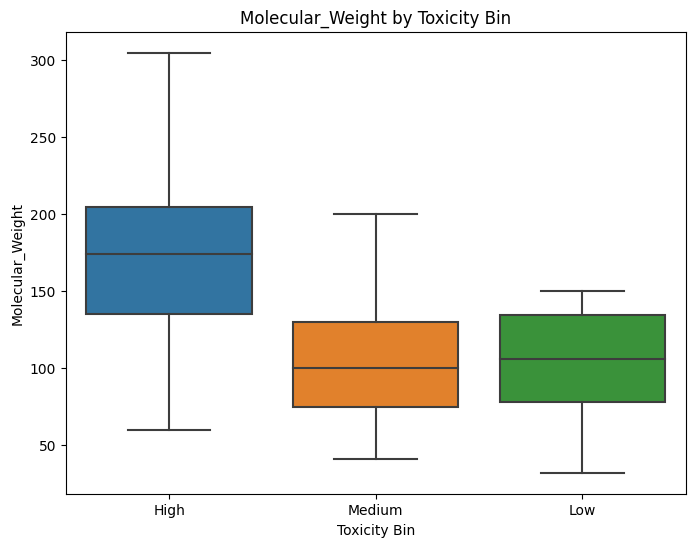

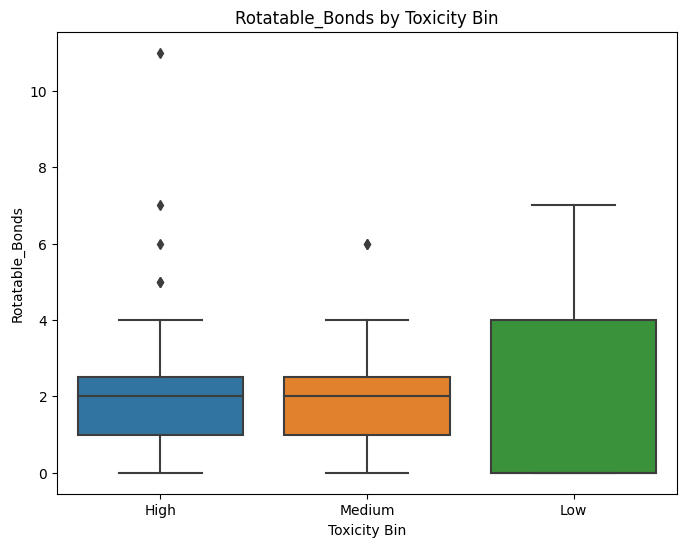

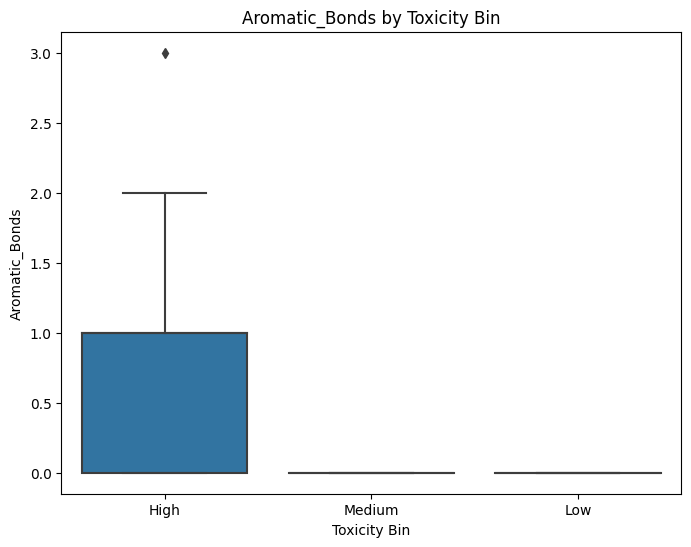

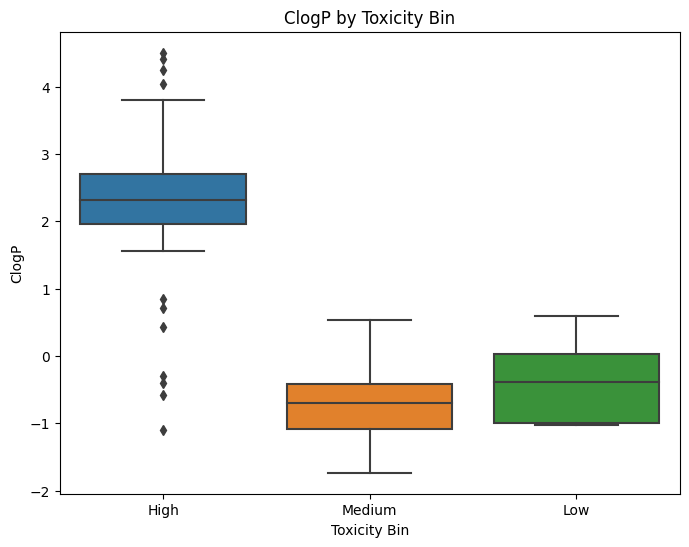

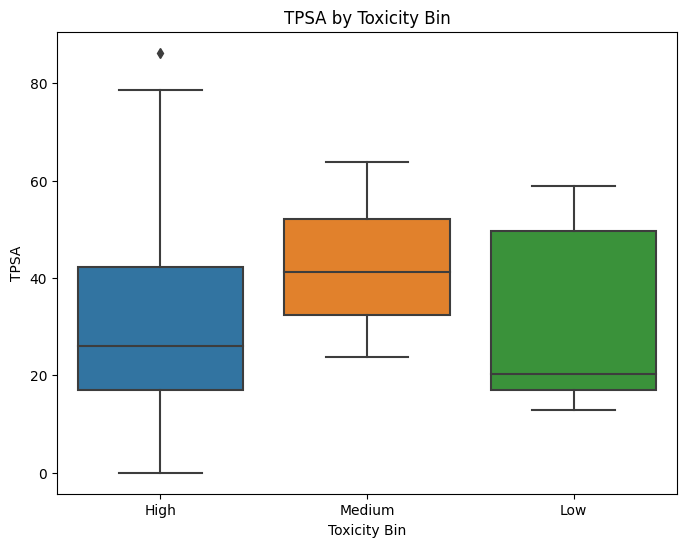

c:\Users\Stephen\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


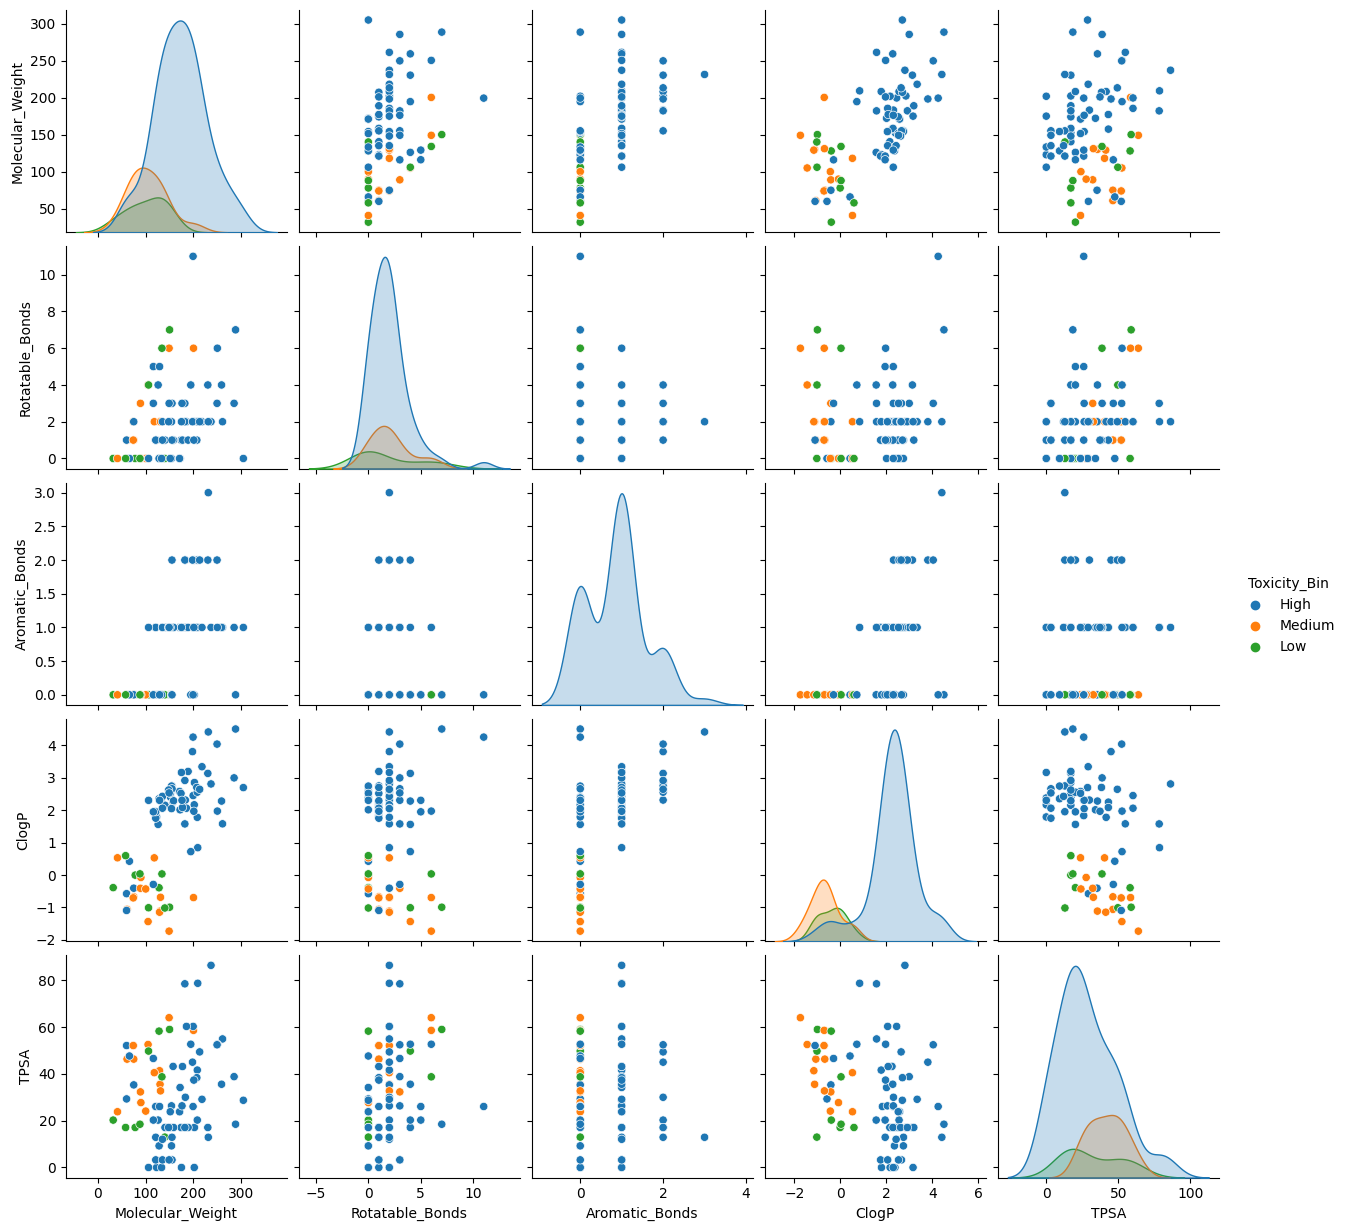

In [58]:
descriptor_data = lc50_df["standardized_mol"].apply(calculate_descriptors)
descriptor_df = pd.DataFrame(descriptor_data.tolist())
lc50_df = pd.concat([lc50_df, descriptor_df], axis=1)

# Bin LC50 values into categories
bins = [0, 10, 100, lc50_df['LC50_mmol'].max()]
labels = ["High", "Medium", "Low"]
lc50_df["Toxicity_Bin"] = pd.cut(lc50_df["LC50_mmol"], bins=bins, labels=labels)


# Boxplots for each descriptor by toxicity bin
for col in ["Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"]:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=lc50_df, x="Toxicity_Bin", y=col)
    plt.title(f"{col} by Toxicity Bin")
    plt.ylabel(col)
    plt.xlabel("Toxicity Bin")
    plt.show()

# Pair plot to explore relationships between descriptors
sns.pairplot(lc50_df, vars=["Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"], hue="Toxicity_Bin")
plt.show()

For Molecular Weight, compounds in the high-toxicity bin tend to have higher molecular weights compared to medium- and low-toxicity bins. This pattern may indicate that larger compounds, potentially with more complex structures, correlate with higher toxicity levels. Similarly, Rotatable Bonds display a noticeable trend where low-toxicity compounds tend to have a greater number of rotatable bonds. This may suggest that structural flexibility plays a role in reducing toxicity. Aromatic Bonds, on the other hand, are predominantly present in the high-toxicity bin, with little to no aromaticity in medium- and low-toxicity compounds, indicating that aromatic structures are more associated with toxicity.

For ClogP, a measure of lipophilicity, compounds in the high-toxicity bin exhibit consistently higher values than those in the medium- and low-toxicity bins, suggesting a potential relationship between increased lipophilicity and greater toxicity. The TPSA values, however, display less variation between the bins, with medium-toxicity compounds showing slightly higher median values compared to high- and low-toxicity compounds. The pair plot further illustrates these relationships, with clear clustering of toxicity bins based on combinations of descriptors like Molecular Weight and Rotatable Bonds.

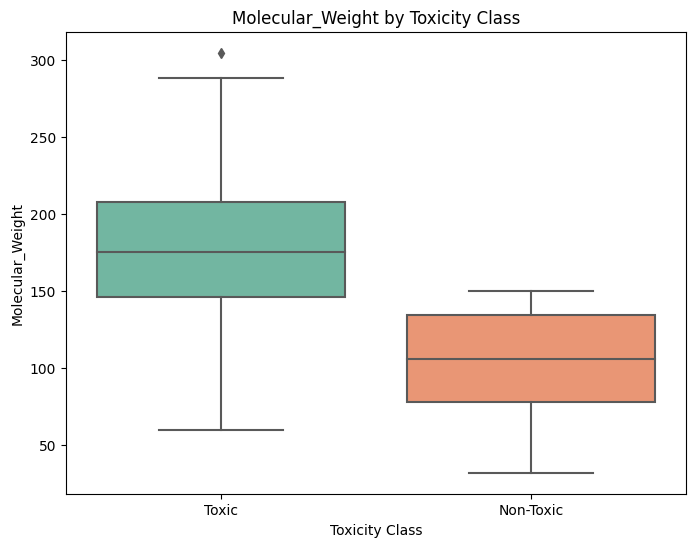

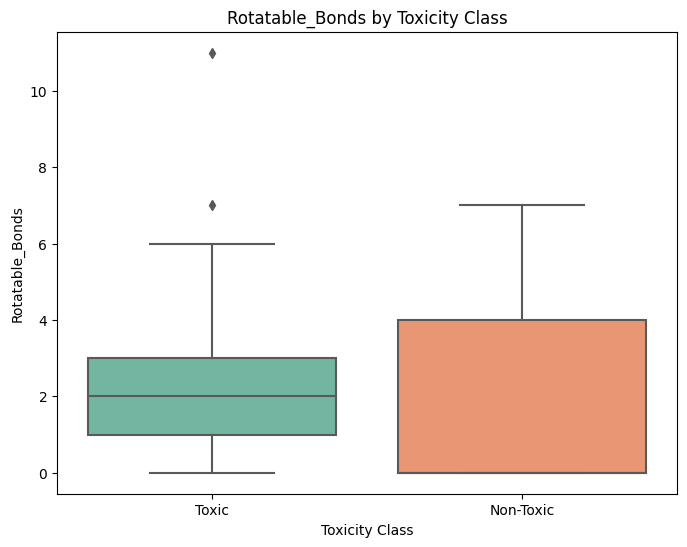

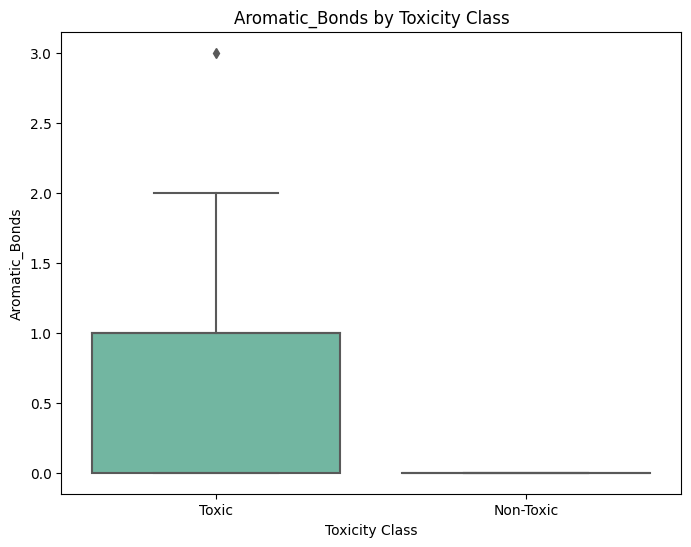

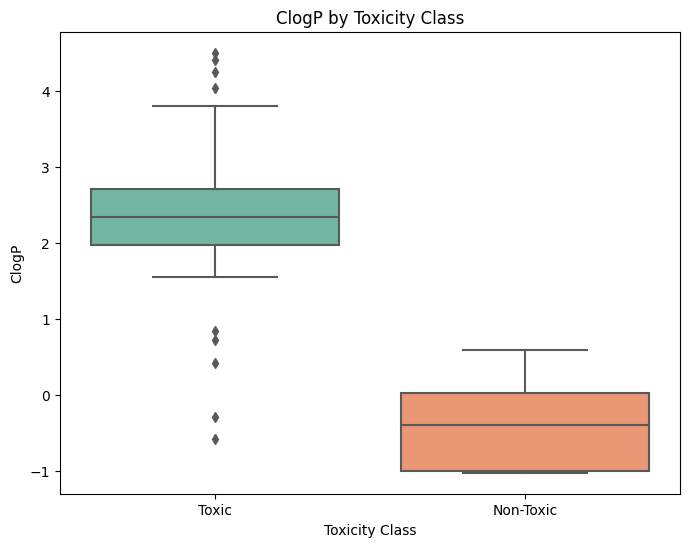

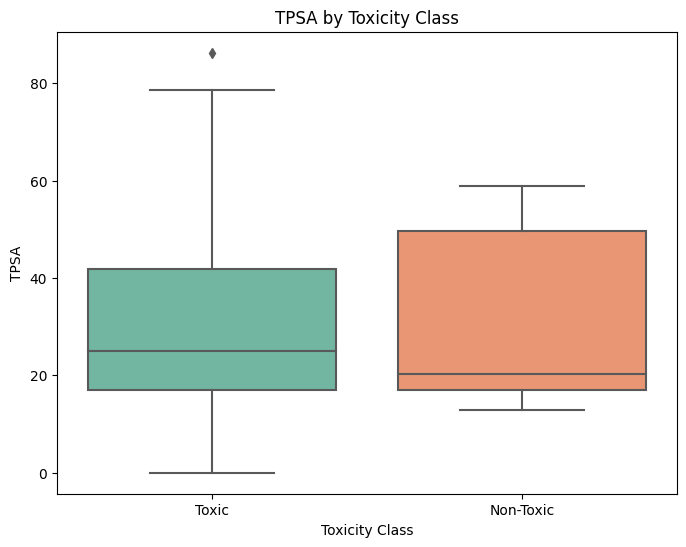

c:\Users\Stephen\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


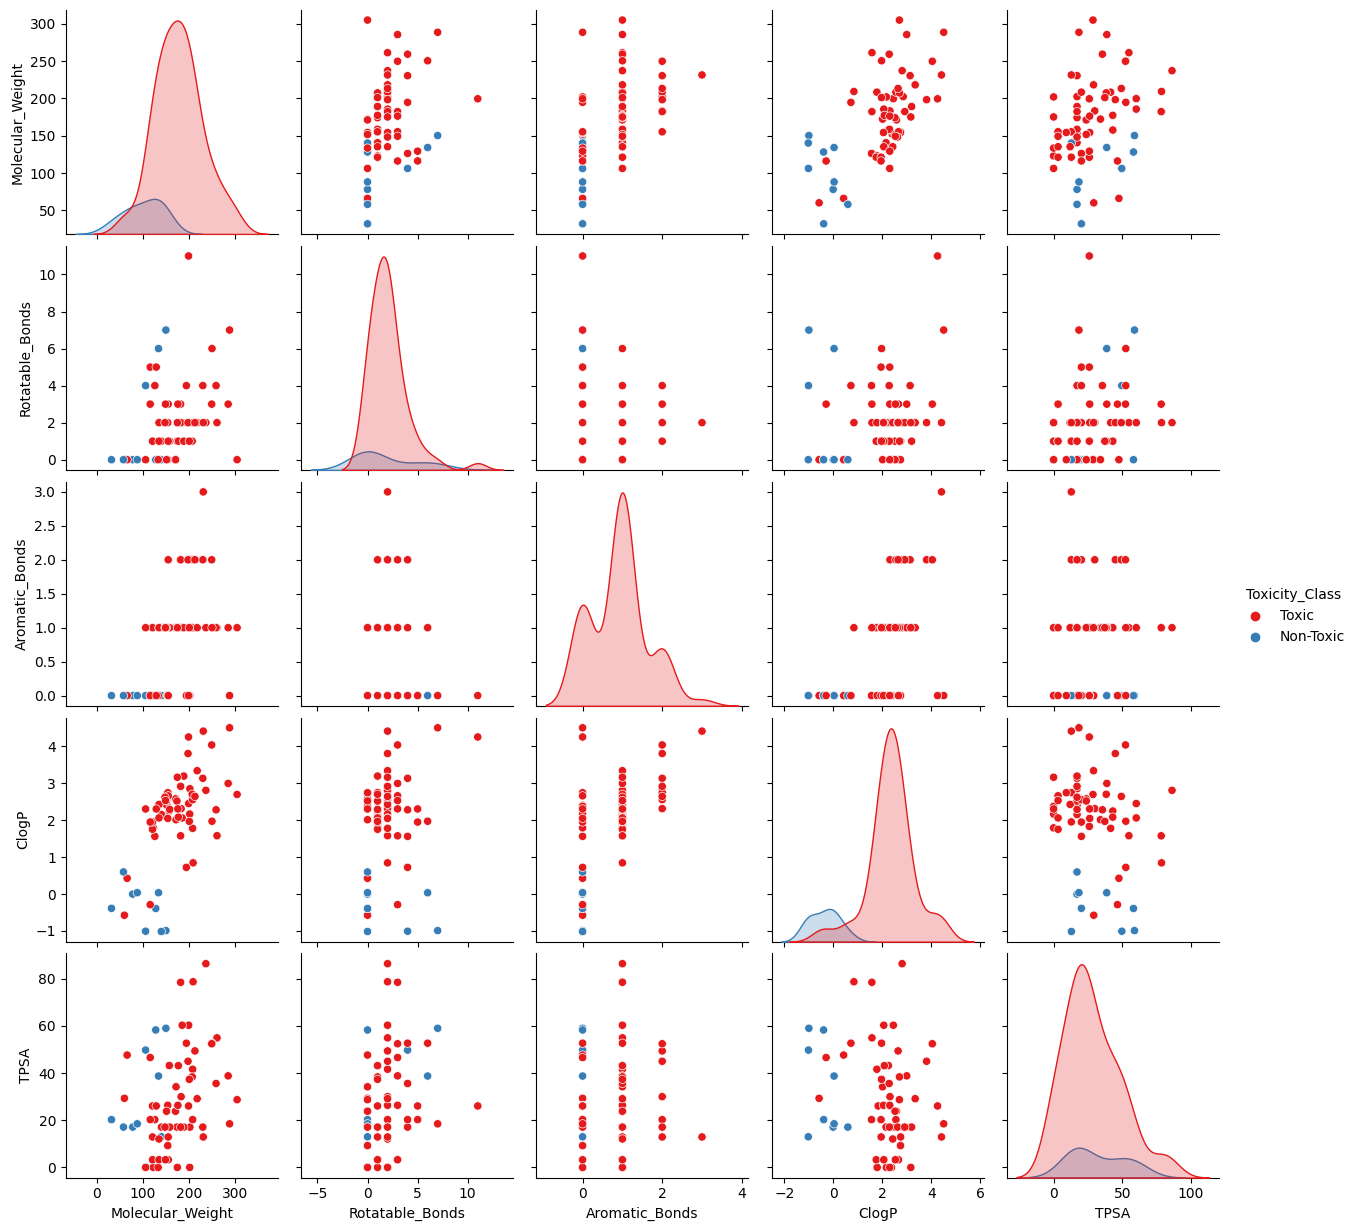

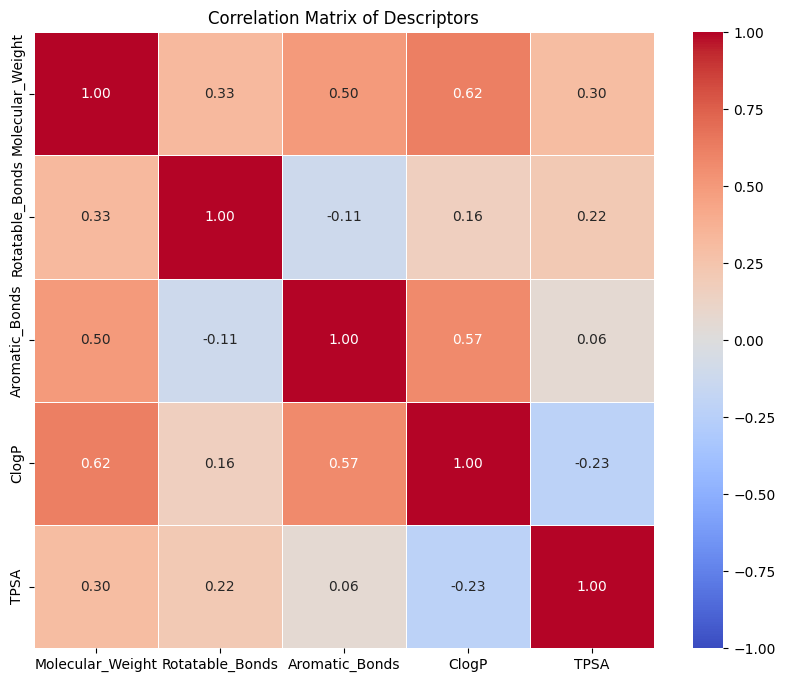

In [59]:
# Filter the dataset to include only Toxic (LC50 <= 1) and Non-Toxic (LC50 > 100); see citation [1]
filtered_lc50_df = lc50_df[(lc50_df["LC50_mmol"] <= 1) | (lc50_df["LC50_mmol"] > 100)].copy()
filtered_lc50_df["Toxicity_Class"] = np.where(filtered_lc50_df["LC50_mmol"] <= 1, "Toxic", "Non-Toxic")

# Boxplots for each descriptor by Toxicity_Class
for col in ["Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"]:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=filtered_lc50_df, x="Toxicity_Class", y=col, palette="Set2")
    plt.title(f"{col} by Toxicity Class")
    plt.ylabel(col)
    plt.xlabel("Toxicity Class")
    plt.show()

sns.pairplot(
    filtered_lc50_df,
    vars=["Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"],
    hue="Toxicity_Class",
    palette="Set1"
)
plt.show()

descriptor_cols = ["Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"]
corr_matrix = filtered_lc50_df[descriptor_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix of Descriptors")
plt.show()



Moving on to a Toxic (LC50 ≤ 1) vs. Non-Toxic (LC50 > 100) analysis, the boxplots and pair plots for the binary classification reveal some more distinct trends in molecular descriptors. The binary classification was calculated based on this paper and their suggested classification for multiple species [1]. Toxic compounds generally have higher molecular weights compared to Non-Toxic ones, as shown by the higher medians and broader distribution in the "Toxic" class, which is in line with results from before. Similarly, the number of aromatic bonds is predominantly higher in the Toxic class, with almost no aromaticity observed in Non-Toxic compounds. Conversely, Non-Toxic compounds tend to have more rotatable bonds, indicating greater structural flexibility. The ClogP values, a measure of lipophilicity, also show a clear distinction, with Toxic compounds being more lipophilic (higher ClogP), while Non-Toxic compounds are more hydrophilic (lower ClogP). TPSA (Topological Polar Surface Area), however, exhibits comparable medians across the two classes, though Toxic compounds display greater variability.

The pair plot highlights relationships between descriptors, with the Toxic and Non-Toxic classes forming distinct clusters in some descriptor combinations. For example, Molecular Weight and Rotatable Bonds exhibit a clear separation between the two classes, with Non-Toxic compounds occupying a lower molecular weight and higher rotatable bond region. The correlation heatmap further supports these findings, showing moderate to strong positive correlations between Molecular Weight and descriptors like Rotatable Bonds and Aromatic Bonds. ClogP is also positively correlated with Molecular Weight and Aromatic Bonds, particularly in Toxic compounds. Overall, the analysis reveals that higher molecular weight, increased aromaticity, and higher lipophilicity are more characteristic of Toxic compounds, whereas greater flexibility and lower molecular weight are associated with Non-Toxic compounds.

1. Lane, T. R., Harris, J., Urbina, F., & Ekins, S. (2023). Comparing LD50/LC50 Machine Learning Models for Multiple Species. Journal of chemical health & safety, 30(2), 83–97. https://doi.org/10.1021/acs.chas.2c00088